
# Forced Alignment with Wav2Vec2



In [1]:
mean = lambda x: sum(x)/len(x)

In [2]:
# fix Audio for vscode notebook
def Audio(path):
    if type(path) is str:
        os.popen(f'cp {path} ./audio-temp.wav') 
        print('please check ./audio-temp.wav for audio')
    elif type(path) is torch.Tensor:
        torchaudio.save('./audio-temp.wav', path, 16000)
        print('please check ./audio-temp.wav for audio')

## Preparation

First we import the necessary packages, and fetch data that we work on.




In [3]:
# %matplotlib inline

import os
from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

matplotlib.rcParams["figure.figsize"] = [16, 5]
matplotlib.rcParams['figure.dpi'] = 200
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from utils.textDecoder import GreedyCTCDecoder, NaiveDecoder

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)
Audio(SPEECH_FILE)

1.11.0
0.11.0
cpu
please check ./audio-temp.wav for audio


## Generate model


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils.helper import get_alphabet_labels, get_phoneme_labels, get_tone_labels, get_pitch_labels

alphabet_labels = get_alphabet_labels()
phoneme_labels = get_phoneme_labels()
tone_labels = get_tone_labels()
pitch_labels = get_pitch_labels()
alphabet_look_up = {s: i for i, s in enumerate(alphabet_labels)} # label转数字
phoneme_look_up = {s: i for i, s in enumerate(phoneme_labels)}
tone_look_up = {s: i for i, s in enumerate(tone_labels)}
pitch_look_up = {s: i for i, s in enumerate(pitch_labels)}

In [6]:
print("labels", phoneme_labels)

labels ('-', '|', 'b', 'p', 'm', 'f', 'd', 't', 'n', 'l', 'g', 'k', 'h', 'j', 'q', 'x', 'zh', 'ch', 'sh', 'r', 'z', 'c', 's', 'y', 'w', 'i', 'u', 'v', 'a', 'ia', 'ua', 'o', 'uo', 'e', 'ie', 've', 'ai', 'uai', 'ei', 'uei', 'ao', 'iao', 'ou', 'iou', 'an', 'ian', 'uan', 'van', 'en', 'in', 'uen', 'vn', 'ang', 'iang', 'uang', 'eng', 'ing', 'ueng', 'ong', 'iong', 'er', 'ê')


# Transfer Learning in Chinese

In [7]:
alphabet_decoder = GreedyCTCDecoder(labels=alphabet_labels)
phoneme_decoder = GreedyCTCDecoder(labels=phoneme_labels)
tone_decoder = GreedyCTCDecoder(labels=tone_labels)

In [8]:
import pypinyin
from pypinyin import lazy_pinyin, Style

In [9]:
def chinese2alphabet(chinese):
    pinyin = lazy_pinyin(chinese, strict=True,errors=lambda x: u'-')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin
def chinese2phoneme(chinese):
    intitials = lazy_pinyin(chinese, strict=False, style=Style.INITIALS, errors=lambda x: u'-')
    finals = lazy_pinyin(chinese, strict=True, style=Style.FINALS, errors=lambda x: u'-')
    result = []
    for i in range(len(intitials)):
        result += ['|']
        if intitials[i] != '':
            result += [intitials[i]]
        elif finals[i] == '':
            result += ['n']
        if finals[i] != '':
            result += [finals[i]]
    return result[1:]
def chinese2tone(chinese):
    pinyin = lazy_pinyin(chinese, strict=True, style=Style.TONE3, neutral_tone_with_five=True, errors=lambda x: u'-')
    tone = [i[-1] for i in pinyin]
    return [i for i in  '|'.join(tone)]

In [10]:
juzi = '诶欸翁谬误于元月云儿嗯捐觉乌好吧'
'`'.join(chinese2alphabet(juzi)), '`'.join(chinese2phoneme(juzi)), '`'.join(chinese2tone(juzi))

('e`i`|`a`i`|`w`e`n`g`|`m`i`u`|`w`u`|`y`u`|`y`u`a`n`|`y`u`e`|`y`u`n`|`e`r`|`n`|`j`u`a`n`|`j`u`e`|`w`u`|`h`a`o`|`b`a',
 'ei`|`ai`|`w`ueng`|`m`iou`|`w`u`|`y`v`|`y`van`|`y`ve`|`y`vn`|`er`|`n`|`j`van`|`j`ve`|`w`u`|`h`ao`|`b`a',
 '2`|`1`|`1`|`4`|`4`|`2`|`2`|`4`|`2`|`2`|`2`|`1`|`2`|`1`|`3`|`5')

In [11]:
from utils.dataset import *

In [12]:
labels_list = [alphabet_labels, phoneme_labels, tone_labels]
translators_list = [chinese2alphabet, chinese2phoneme, chinese2tone]
decoders = [alphabet_decoder, phoneme_decoder, tone_decoder]

In [13]:
class MultiTaskRawLoaderGenerator:
    def __init__(self, 
        labels_list:list, 
        translators_list: list,
        k_size=0, 
        num_workers=0,
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        ) -> None:
        self.k_size = k_size
        self.labels_list = labels_list
        self.look_up_list = [{s: i for i, s in enumerate(labels)} for labels in labels_list]
        self.device = device
        self.num_workers = num_workers

    def label2id(self, label_set:int, str):
        return [self.look_up_list[label_set][i] for i in str]

    def id2label(self, label_set:int, idcs):
        return ''.join([self.labels_list[label_set][i] for i in idcs])

    def batch_filter(self, batch:list):
        # remove all audio with tag if audio length > threshold
        for i in range(len(batch)-1, -1, -1):
            if batch[i]['audio'].shape[-1] > self.threshold: # 256 is the hop_length of fft
                del batch[i]
        return batch

    def collate_wrapper(self, batch:list): # RAW
        batch = self.batch_filter(batch)
        bs = len(batch)
        rand_shift = torch.randint(self.k_size, (bs,))
        audio_list = [batch[i]['audio'][:,rand_shift[i]:] for i in range(bs)]
        audio_length = [audio.shape[-1] for audio in audio_list]
        audio_length = torch.tensor(audio_length)
        max_audio_length = torch.max(audio_length)
        audio_list = torch.cat([
            torch.cat(
            (audio, torch.zeros(max_audio_length-audio.shape[-1]).unsqueeze(0)), -1)
            for audio in audio_list], 0)

        all_target_list = []
        all_target_length = []
        for label_set in range(len(self.labels_list)):
            target_list = [self.label2id(label_set, translators_list[label_set](item['chinese'])) for item in batch]
            target_length = [len(l) for l in target_list]
            target_length = torch.tensor(target_length)
            max_target_length = torch.max(target_length)
            target_list = torch.cat([
                torch.cat(
                (torch.tensor(l), torch.zeros([max_target_length-len(l)], dtype=torch.int)), -1).unsqueeze(0) 
                for l in target_list], 0)
            all_target_list.append(target_list)
            all_target_length.append(target_length)
        return {'audio': audio_list, 'audio_len': audio_length, 
                'target': all_target_list, 'target_len': all_target_length}

    def dataloader(self, audioDataset, batch_size, shuffle=True):
        def max_threshold_in_concat_set(concat_set):
            max_threshold = 0
            for dataset in concat_set.datasets:
                max_threshold = max(dataset.dataset.threshold, max_threshold)
            return max_threshold
        # k_size is the kernel size for the encoder, for data augmentation
        self.threshold = max_threshold_in_concat_set(audioDataset)
        return DataLoader(audioDataset, batch_size,
                            shuffle, num_workers=self.num_workers, collate_fn=self.collate_wrapper)

In [14]:
def raw_audio_transform(sample, sample_rate=None):
        audio = sample['audio']
        audio = audio / torch.abs(audio).max()*0.15
        text = sample['text']
        # pinyin = chinese2pinyin(text)
        # pinyin = ''.join(pinyin) # 使用空格分离单字
        chinese = text
        sample['audio'] = audio
        # sample['text'] = pinyin
        sample['chinese'] = chinese
        return sample

dataset = PrimeWordsDataset('/scratch/bh2283/data/primewords_md_2018_set1/', transform=raw_audio_transform)

In [15]:
dataset1 = PrimeWordsDataset('/scratch/bh2283/data/primewords_md_2018_set1/', transform=raw_audio_transform)
# dataset2 = STCMDSDataset('/ST-CMDS-20170001_1-OS/', transform=raw_audio_transform) # singularity usage only
# dataset3 = AiShellDataset('/scratch/bh2283/data/data_aishell/', transform=raw_audio_transform)
# dataset4 = AiDataTangDataset('/aidatatang_200zh/', transform=raw_audio_transform) # singularity usage only
# dataset5 = AiShell3Dataset('/scratch/bh2283/data/data_aishell3/train/', transform=raw_audio_transform)
# dataset6 = SpeechOceanDataset('/scratch/bh2283/data/zhspeechocean/', transform=raw_audio_transform)
# datasets = [dataset1, dataset3, dataset5, dataset6]
datasets = [dataset1]

train_sets = []
test_sets = []
for dataset in datasets:
    train_set, test_set = dataset.split()
    train_sets.append(train_set)
    test_sets.append(test_set)

train_set = torch.utils.data.ConcatDataset(train_sets)
test_set = torch.utils.data.ConcatDataset(test_sets)

print('train_set:', len(train_set), 'test_set:',len(test_set))

train_set: 50498 test_set: 404


In [16]:
from model.wav2vec2 import Wav2Vec2Builder

labels_sizes = [len(labels) for labels in labels_list]
builder = Wav2Vec2Builder(torchaudio.pipelines.VOXPOPULI_ASR_BASE_10K_EN, labels_sizes)
model = builder.get_model()
builder.kernel_size

10

In [17]:
# model

In [18]:
batch_size = 8
# train_set, test_set = dataset.split([1000, 5])
k_size = builder.kernel_size # kernel size for audio encoder
k_size

10

In [19]:
loaderGenerator = MultiTaskRawLoaderGenerator(labels_list, translators_list, k_size)
train_loader = loaderGenerator.dataloader(train_set, batch_size)
test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
print('train_set:', len(train_set), 'test_set:',len(test_set))

train_set: 50498 test_set: 404


In [20]:
test_set[2]

{'audio': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0002, 0.0002, 0.0002]]),
 'text': '二零一一年参演电视剧 五 二零一二年',
 'chinese': '二零一一年参演电视剧 五 二零一二年'}

In [21]:
torchaudio.save('audio-temp.wav', test_set[2]['audio'], 16000)
test_set[2]

{'audio': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0002, 0.0002, 0.0002]]),
 'text': '二零一一年参演电视剧 五 二零一二年',
 'chinese': '二零一一年参演电视剧 五 二零一二年'}

In [22]:
for i_batch, sample_batched in enumerate(train_loader):
    print(sample_batched['audio'].shape, sample_batched['audio_len'])
    for i in range(len(sample_batched['target'])):
        print(sample_batched['target'][i].shape, '\n', sample_batched['target_len'][i])
        
    # print(sample_batched['target'][2])
    # print(sample_batched)
    # for i in sample_batched['audio']:
    #     print(i.shape)
    break

torch.Size([8, 153919]) tensor([143993,  90233,  82558, 131840,  99837, 153919,  97920, 140475])
torch.Size([8, 112]) 
 tensor([110,  94,  79,  89,  84,  89,  81, 112])
torch.Size([8, 88]) 
 tensor([80, 67, 68, 71, 62, 68, 61, 88])
torch.Size([8, 59]) 
 tensor([53, 45, 45, 47, 41, 45, 41, 59])


In [23]:
o, l = model(sample_batched['audio'], sample_batched['audio_len'])

label_set = 0
batch_idx = 2
o[label_set].shape, l.shape

(torch.Size([8, 480, 28]), torch.Size([8]))

In [24]:
emissions = torch.log_softmax(o[label_set], dim=-1)
print(emissions.shape)
# idx = torch.argmax(emissions, -1)
transcript = decoders[label_set](emissions[0]) #loaderGenerator.id2label(label_set, idx[batch_idx])
# transcript

torch.Size([8, 480, 28])


In [25]:
ctc_loss = torch.nn.CTCLoss(zero_infinity=True)
print(emissions.shape, sample_batched['target'][label_set].shape, l.shape, sample_batched['target_len'][label_set].shape)
loss = ctc_loss(emissions.permute(1,0,2), sample_batched['target'][label_set], l, sample_batched['target_len'][label_set])
loss

torch.Size([8, 480, 28]) torch.Size([8, 112]) torch.Size([8]) torch.Size([8])


tensor(9.9334, grad_fn=<MeanBackward0>)

## Try to save/load checkpoint

In [282]:
from os.path import exists
LOAD_PATH = './checkpoint/wav2vec/model_temp.pt'
def load_checkpoint(path):
    if exists(path):
        print('file',path,'exist, load checkpoint...')
        checkpoint = torch.load(path, map_location=device)
        print(checkpoint.keys())
        if 'model_aux_dict' in checkpoint:
            model.aux.load_state_dict(checkpoint['model_aux_dict'])
        # if 'model_state_dict' in checkpoint:
        #     model.aux[0].load_state_dict(checkpoint['model_state_dict'])
        if 'model_encoder_dict' in checkpoint:
            model.encoder.load_state_dict(checkpoint['model_encoder_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(epoch, loss)
load_checkpoint(LOAD_PATH)

file ./checkpoint/wav2vec/model_temp.pt exist, load checkpoint...
dict_keys(['epoch', 'model_aux_dict', 'model_encoder_dict', 'model_feature_extractor_dict', 'optimizer_state_dict', 'loss'])
0 0.3427284323002981


In [283]:
params = list(model.encoder.parameters()) + list(model.aux.parameters())
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
ctc_loss = torch.nn.CTCLoss(zero_infinity=True)

In [284]:
naive_decoders = [NaiveDecoder(labels=alphabet_labels), NaiveDecoder(labels=phoneme_labels), NaiveDecoder(labels=tone_labels)]

In [285]:
def test(k):
    model.eval()
    with torch.no_grad():
        get_transcript = lambda x, emissions: decoders[x](torch.log_softmax(emissions[x][0], dim=-1).cpu().detach())
        for i in range(k):
            sample = test_set[i]
            print(i, sample['audio'].shape, sample['chinese'])
            waveform = sample['audio']
            emissions, _ = model(waveform.to(device))
            print('Char level:', get_transcript(0, emissions),
                '\nPhon level:', get_transcript(1, emissions),
                '\nTone level:', get_transcript(2, emissions),)
# test(3)

In [286]:
torchaudio.save('audio-temp.wav', test_set[5]['audio'], 16000)

In [287]:
def save_checkpoint(EPOCH, LOSS):
    PATH = f"./checkpoint/wav2vec/model_{EPOCH}_{LOSS}.pt"
    torch.save({
            'epoch': EPOCH,
            'model_aux_dict': model.aux.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)
    print(f'saved checkpoint to {PATH}')

In [288]:
# save_checkpoint(1, 1)

In [33]:
def blank_loss(emission, emission_len, blank_id=0, margin=0):
    # input emission with shape [time, bs, class]
    # input emission_len with shape [bs]
    blank_emission_p = torch.exp(emission[:, :, blank_id]) # probability of blank
    blank_emission_p = torch.relu(blank_emission_p - margin) # dismiss if less than margin
    mask = torch.arange(max(emission_len))[:, None].to(device) < emission_len[None, :]
    # print(blank_emission_p)
    # print(mask)
    blank_emission_p_masked = blank_emission_p * mask # apply mask
    # print(blank_emission_p_masked)
    mean_axis = torch.sum(blank_emission_p_masked, dim=0)/emission_len # mean blank p in axis
    # print(mean_axis)
    return torch.mean(mean_axis)

blank_loss(torch.tensor([
    [[-.2],[-.2],[-.2],[-.2]],
    [[0],[-.2],[-.2],[-.2]],
    [[0],[0],[-.2],[-.2]],
    [[0],[0],[0],[-.2]]
]), 
torch.Tensor([1, 2,3,4]),
0,
0.4)

tensor(0.4187)

In [34]:
def train(epoch=1):
    train_loss_q = []
    test_loss_q = []
    for epoch in range(0, epoch):
        
        batch_train_loss = []
        for i_batch, sample_batched in enumerate(train_loader):
            model.train()
            # Step 1. Prepare Data
            waveform = sample_batched['audio'].to(device)
            wave_len = sample_batched['audio_len'].to(device)
            target = [sample_batched['target'][i].to(device) for i in range(len(sample_batched['target']))]
            target_len = [sample_batched['target_len'][i].to(device) for i in range(len(sample_batched['target_len']))]
            al_t, ph_t, tn_t = target[0], target[1], target[2]
            al_l, ph_l, tn_l = target_len[0], target_len[1], target_len[2]

            # Step 2. Run our forward pass
            emissions, emission_len = model(waveform, wave_len)
            emissions = [torch.log_softmax(emission, dim=-1).permute(1,0,2) for emission in emissions]
            al, ph, tn = emissions
            al_loss = ctc_loss(al, al_t, emission_len, al_l)
            ph_loss = ctc_loss(ph, ph_t, emission_len, ph_l)
            tn_loss = ctc_loss(tn, tn_t, emission_len, tn_l)

            # Step 3. Run our backward pass
            optimizer.zero_grad()
            loss = al_loss + ph_loss + tn_loss
            loss.backward()
            optimizer.step()

            if loss.item()!=loss.item(): # if loss == NaN, break
                print('NaN hit!')
                exit()
            
            batch_train_loss.append(loss.item())

            print(al.shape, emission_len.shape)
            b_loss = blank_loss(al, emission_len)

            print(al_loss.item(), ph_loss.item(), tn_loss.item(), b_loss.item())
            break

            if i_batch % (1000 // batch_size) == 0: # log about each 1000 data
                test_loss = test()
                # test_loss = 0
                train_loss = mean(batch_train_loss)
                test_loss_q.append(test_loss)
                train_loss_q.append(train_loss)
                # save_log(f'e{epoch}.txt', ['🟣 epoch', epoch, 'data', i_batch*batch_size, 
                #     'lr', scheduler.get_last_lr(), 
                #     'train_loss', train_loss, 'test_loss', test_loss])
                # save_temp(epoch, test_loss) # save temp checkpoint
                # test_decoder(epoch, 5)
            
        scheduler.step()
        # save_checkpoint(epoch, mean(test_loss_q))
        # save_log(f'e{epoch}.txt', ['============= Final Test ============='])
        # test_decoder(epoch, 10) # run some sample prediction and see the result

train()

torch.Size([404, 8, 28]) torch.Size([8])
0.22317206859588623 0.10366497933864594 0.04233178496360779 0.3037146329879761


In [555]:
with torch.no_grad():
    i = 210 # 13
    sample = test_set[i]
    Audio(sample['audio'])
    # print(type(sample['audio']))
    print(i, sample['audio'].shape, sample['text'])
    waveform = sample['audio']
    emissions, emissions_length = model(waveform.to(device))

get_transcript = lambda x, emissions: ''.join(decoders[x](torch.log_softmax(emissions[x][0], dim=-1).cpu().detach()))
get_transcript(0, emissions), get_transcript(1, emissions), get_transcript(2, emissions)

please check ./audio-temp.wav for audio
210 torch.Size([1, 80640]) 陶瓷紫砂随意 新茶巾 小毛巾 一条


('|to|chi|zhi|sha|shui|yi||xin|cha|jin|xiao|mao|jin|yi|tiao|',
 'tao|ci|zhi|sha|shuei|yi|xin|cha|jin||xiao|mao|jin|yi|tiao',
 '2|2|3|2|3|4|1|2|1||3|2|1|1|2')

### Visualization



In [556]:
emissions_length

In [557]:
emissions[0].shape

torch.Size([1, 251, 28])

In [558]:
type_code = 0 # 0 for char, 1 for phon;
labels = labels_list[type_code]
emission = torch.log_softmax(emissions[type_code][0], dim=-1)
transcript = decoders[type_code](torch.log_softmax(emission, dim=-1))
emission.shape, ''.join(transcript)

(torch.Size([251, 28]),
 '|to|chi|zhi|sha|shui|yi||xin|cha|jin|xiao|mao|jin|yi|tiao|')

In [559]:
# transcript='|zui|chou|yi|shun|jian||pa|gan|bao|jing|huan|he|kun|huo|'

('-', '|', 'e', 't', 'o', 'i', 'a', 'n', 's', 'r', 'h', 'l', 'd', 'c', 'u', 'm', 'p', 'f', 'g', 'w', 'y', 'b', 'v', 'k', 'x', 'j', 'q', 'z')


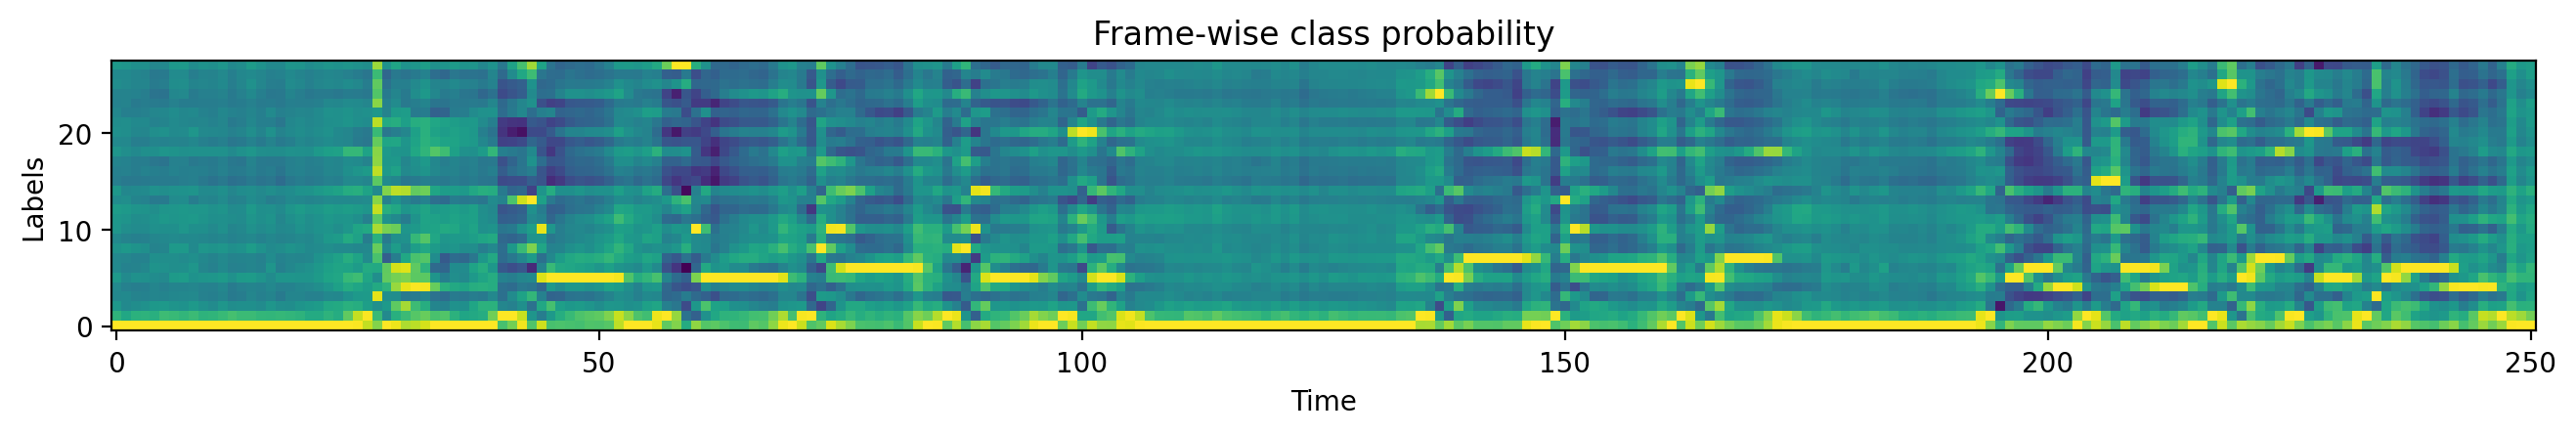

In [560]:
print(labels)
plt.imshow(emission.T, interpolation=None, origin="lower")
# plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [561]:
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame + 1, num_tokens + 1), -float("inf"))
    trellis[:, 0] = 0
    for t in range(num_frame):
        # print(emission[t, blank_id])
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id]*0.9,
            torch.maximum(
                # Score for changing to the next token
                trellis[t, :-1] + emission[t, tokens]*0.5,
                # Score for repeat at the same token
                trellis[t, 1:] + emission[t, tokens]*1.4,
            )
        )
    return trellis
# 0.9, 0.5, 2.0 可以抹除掉空白
# 0.5, 2, 1.5 有空白，但是起点把握更好

trellis = get_trellis(emission, tokens)

[('|', 1), ('t', 3), ('o', 4), ('|', 1), ('c', 13), ('h', 10), ('i', 5), ('|', 1), ('z', 27), ('h', 10), ('i', 5), ('|', 1), ('s', 8), ('h', 10), ('a', 6), ('|', 1), ('s', 8), ('h', 10), ('u', 14), ('i', 5), ('|', 1), ('y', 20), ('i', 5), ('|', 1), ('|', 1), ('x', 24), ('i', 5), ('n', 7), ('|', 1), ('c', 13), ('h', 10), ('a', 6), ('|', 1), ('j', 25), ('i', 5), ('n', 7), ('|', 1), ('x', 24), ('i', 5), ('a', 6), ('o', 4), ('|', 1), ('m', 15), ('a', 6), ('o', 4), ('|', 1), ('j', 25), ('i', 5), ('n', 7), ('|', 1), ('y', 20), ('i', 5), ('|', 1), ('t', 3), ('i', 5), ('a', 6), ('o', 4), ('|', 1)]


In [562]:
NaiveDecoder(labels)(emission)

'--------------------------|t--ooo-------||-chiiiiiiii---||zzhiiiiiiii--||shhaaaaaaaa--||shuiiii---||yyii-|-----------------------------||xiinnnnnn---|chaaaaaaaaa-|jjiinnnnn----------------------|xiiaaaoo-|mmmaaaaooo--||jiinnn||yyiii-|tiiaaaaaooooo|---'

### Visualization



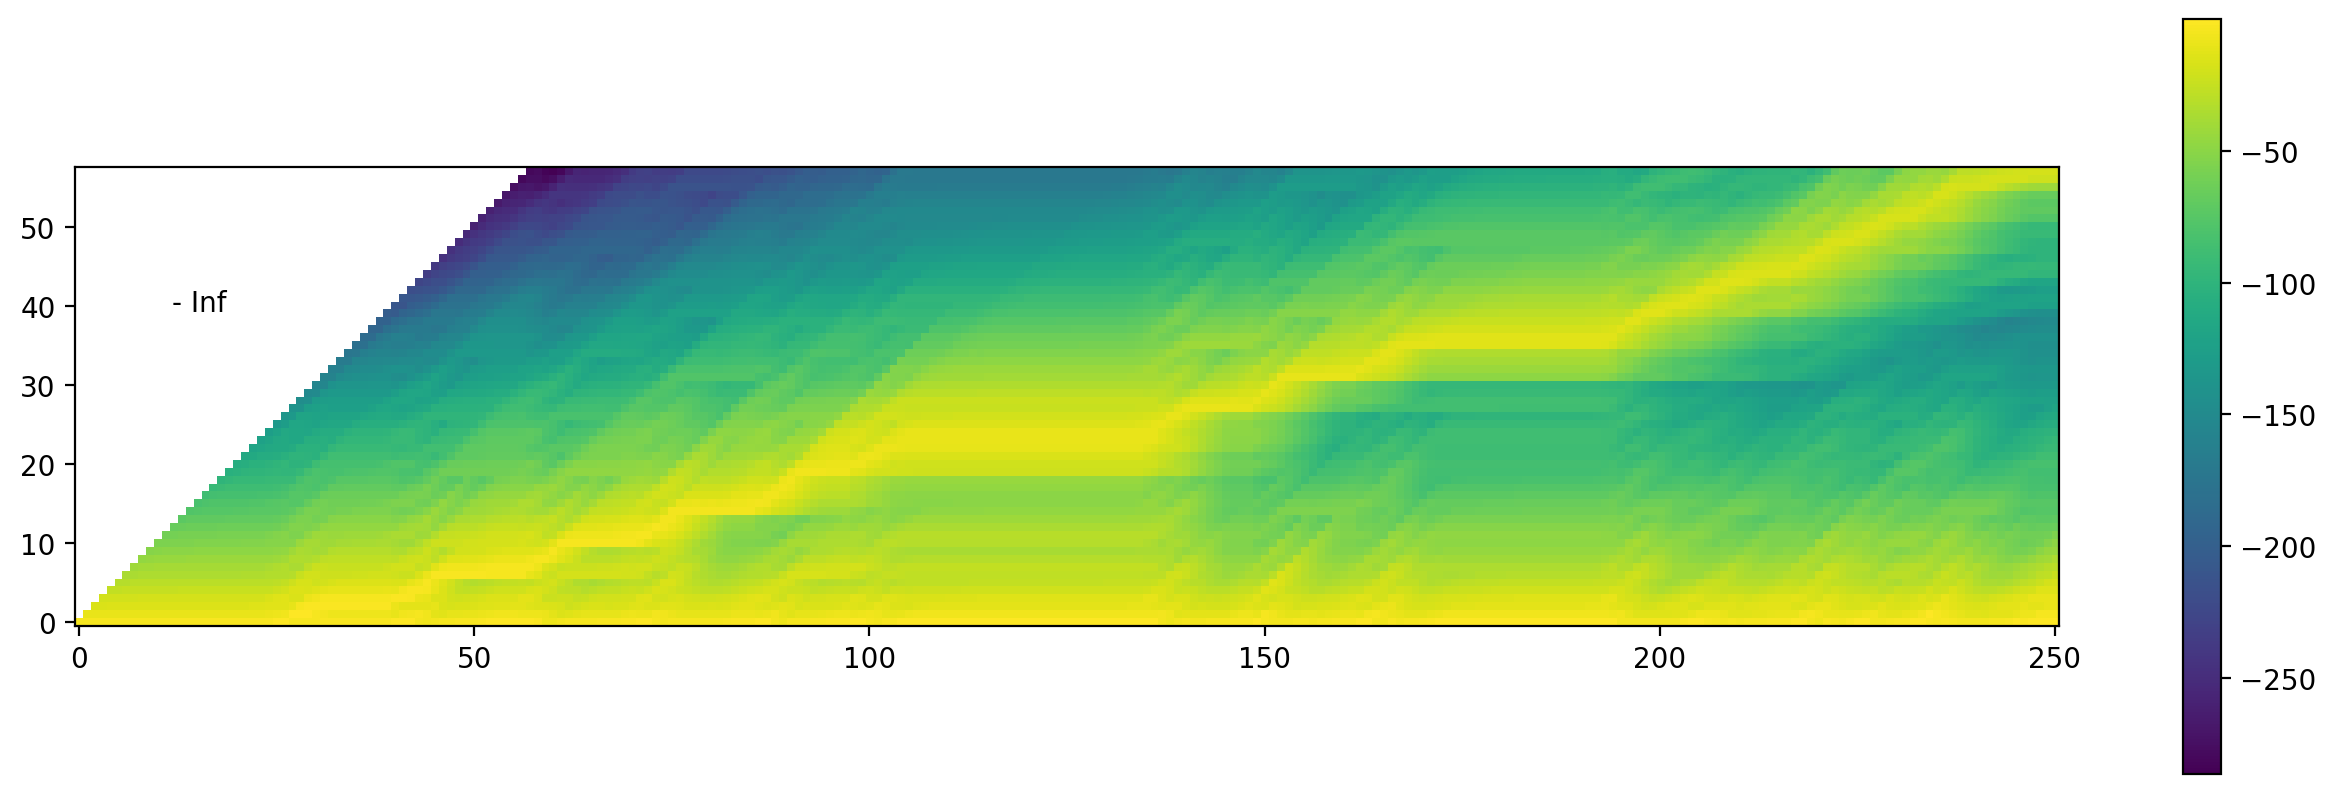

In [563]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.




## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.




In [564]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()
    t_start = len(trellis[:, j])-1

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
# print(path)

### Visualization



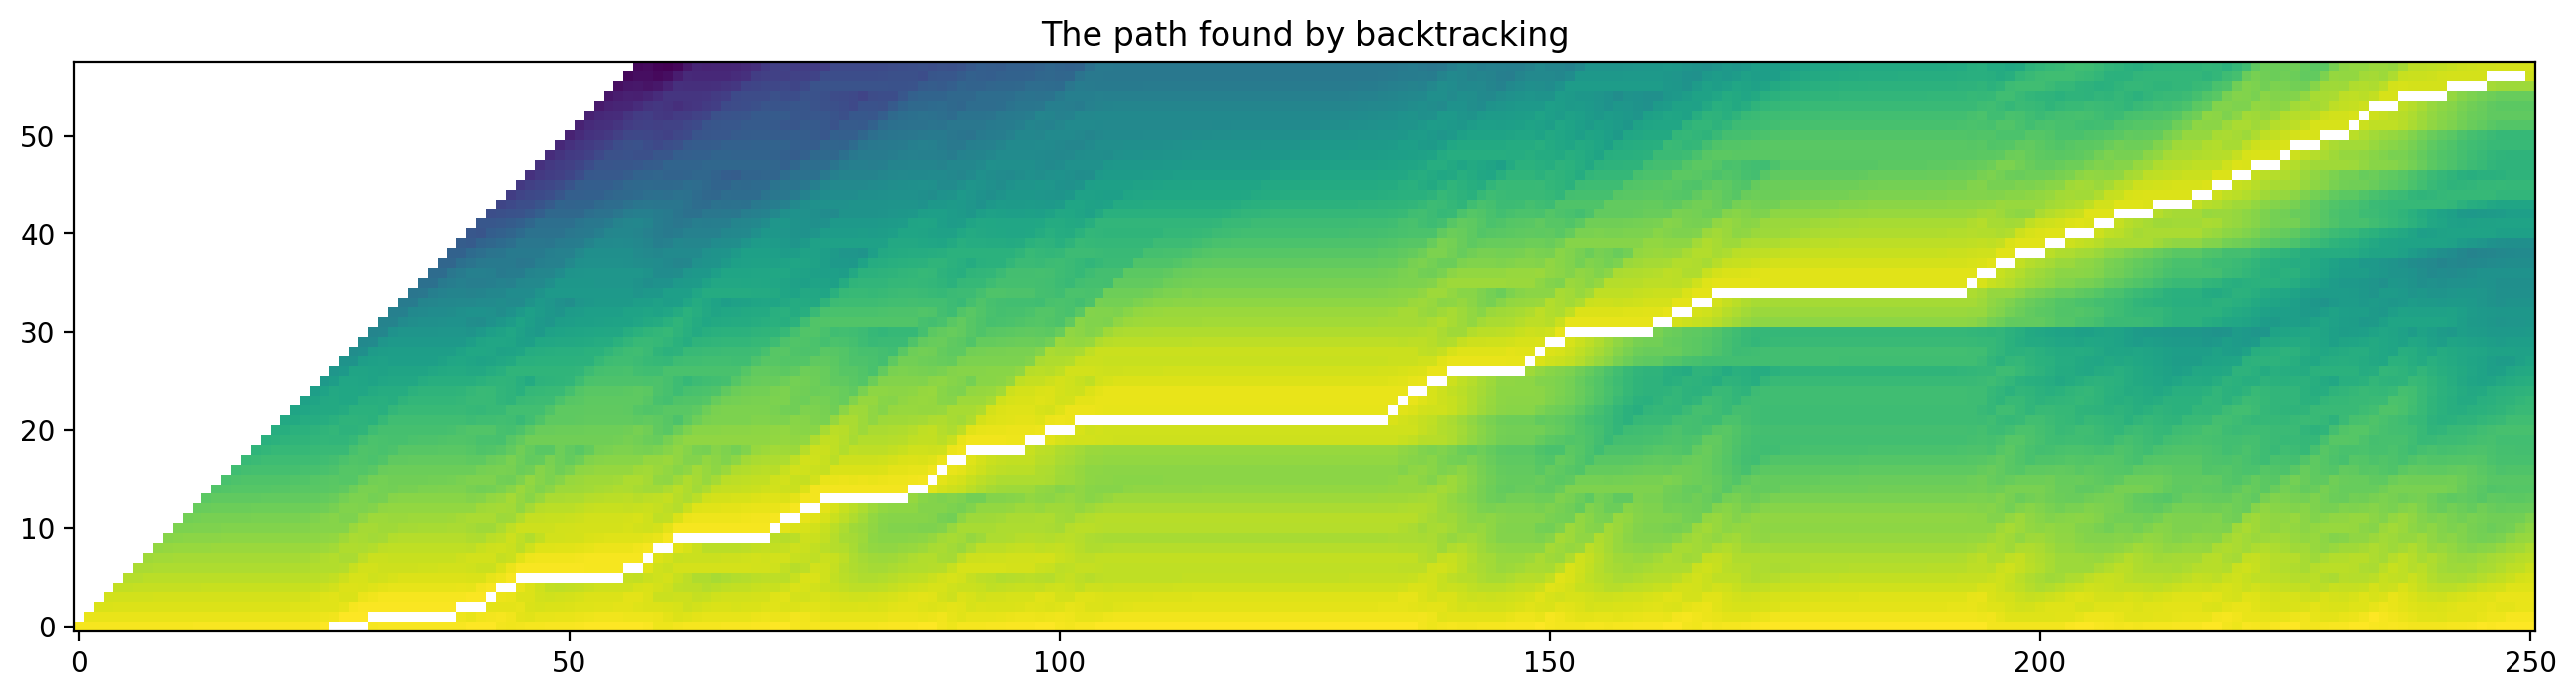

In [565]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

Looking good. Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.




In [566]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

|	(0.86): [   26,    27)
t	(0.51): [   27,    31)
o	(0.90): [   31,    40)
|	(0.55): [   40,    43)
c	(0.94): [   43,    44)
h	(0.25): [   44,    46)
i	(0.41): [   46,    57)
|	(0.50): [   57,    59)
z	(1.00): [   59,    60)
h	(0.48): [   60,    62)
i	(0.28): [   62,    72)
|	(1.00): [   72,    73)
s	(0.64): [   73,    75)
h	(0.37): [   75,    77)
a	(0.34): [   77,    86)
|	(0.54): [   86,    88)
s	(0.99): [   88,    89)
h	(0.56): [   89,    90)
u	(0.33): [   90,    92)
i	(0.59): [   92,    98)
|	(0.58): [   98,   100)
y	(0.38): [  100,   103)
i	(0.96): [  103,   135)
|	(0.94): [  135,   136)
|	(0.89): [  136,   137)
x	(0.51): [  137,   139)
i	(0.45): [  139,   141)
n	(0.41): [  141,   149)
|	(1.00): [  149,   150)
c	(0.97): [  150,   151)
h	(0.48): [  151,   153)
a	(0.23): [  153,   162)
|	(0.59): [  162,   164)
j	(0.58): [  164,   166)
i	(0.40): [  166,   168)
n	(0.84): [  168,   194)
|	(0.97): [  194,   195)
x	(0.50): [  195,   197)
i	(0.50): [  197,   199)
a	(0.35): [  199,   202)


In [567]:
# # Merge the labels
# @dataclass
# class Segment:
#     label: str
#     start: int
#     end: int
#     score: float

#     def __repr__(self):
#         return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

#     @property
#     def length(self):
#         return self.end - self.start

# def merge_repeats(path):
#     i1, i2 = 0, 0
#     segments = []
#     while i1 < len(path):
#         while i2 < len(path) and path[i1].token_index == path[i2].token_index:
#             i2 += 1
            
                
#         score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1 + 1)
        
#         segments.append(
#             Segment(
#                 transcript[path[i1].token_index],
#                 path[i1].time_index,
#                 path[i2 - 1].time_index + 1,
#                 score,
#             )
#         )
#         i1 = i2
#     return segments


# segments = merge_repeats(path)
# for seg in segments:
#     print(seg)

### Visualization



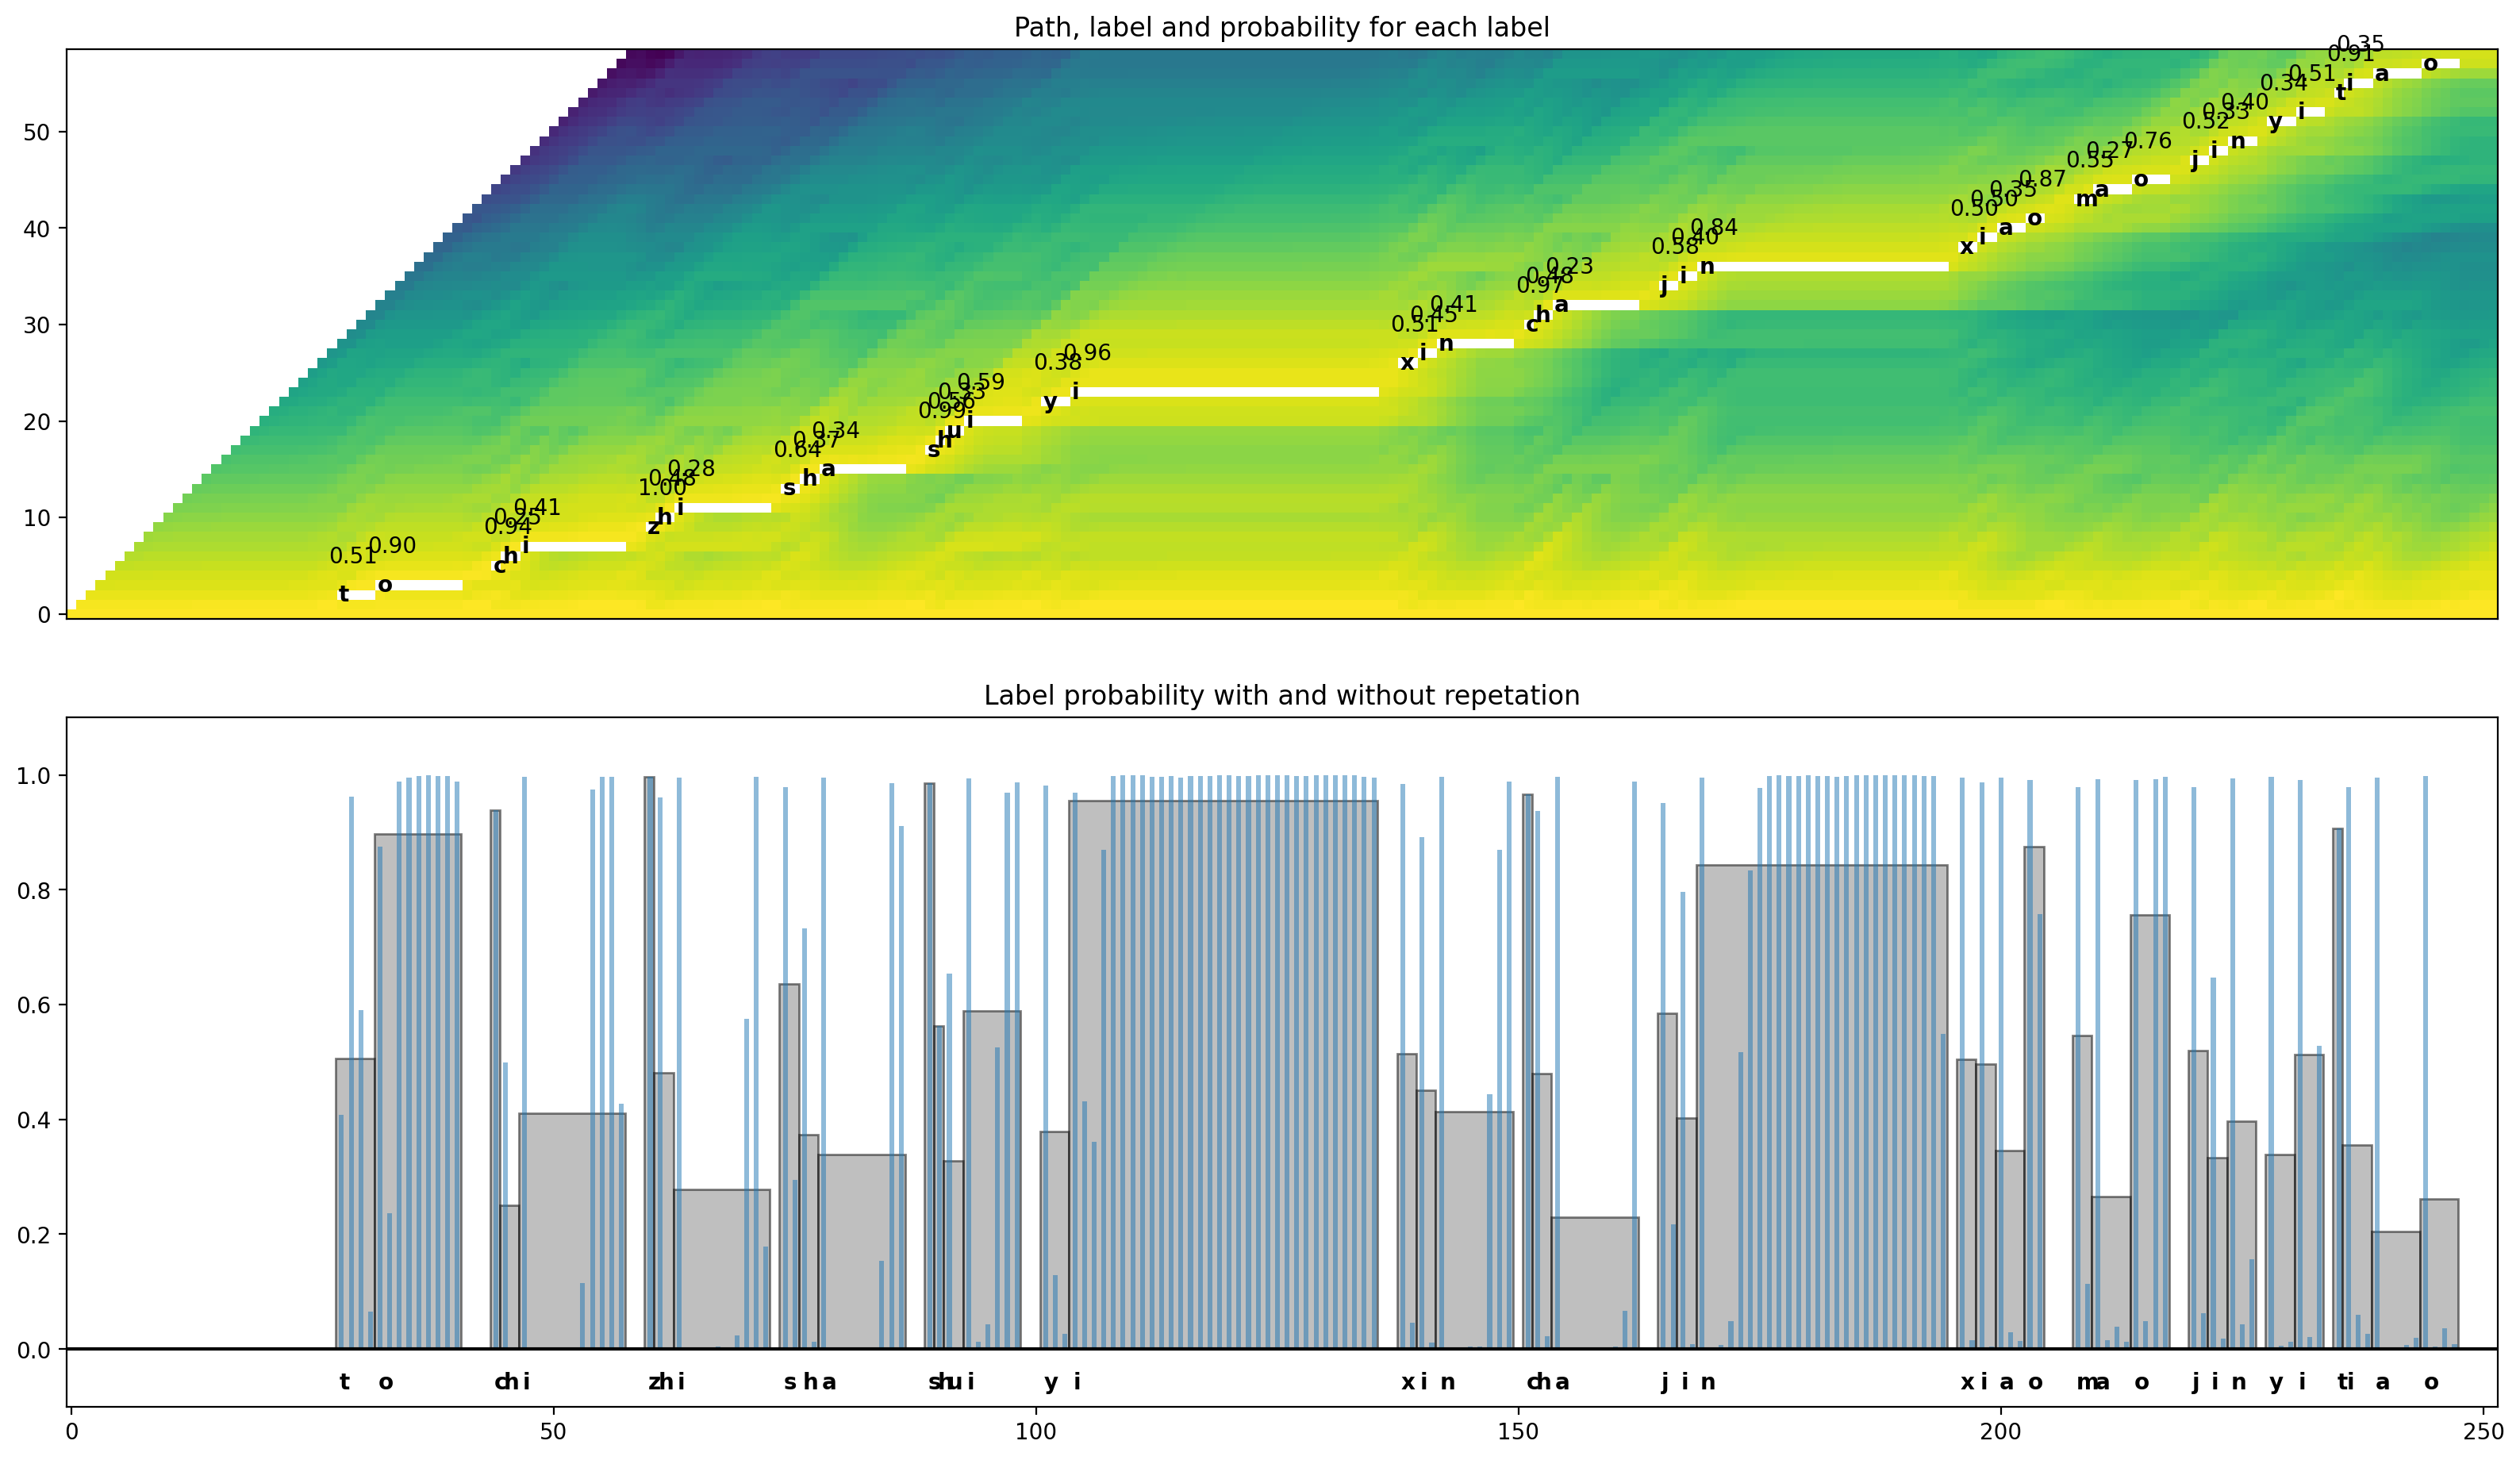

In [568]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    
    for i, seg in enumerate(segments):
        # if seg.label == '|':
        #     seg.label = ","
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")
        

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)
    


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

Looks good. Now let’s merge the words. The Wav2Vec2 model uses ``'|'``
as the word boundary, so we merge the segments before each occurance of
``'|'``.

Then, finally, we segment the original audio into segmented audio and
listen to them to see if the segmentation is correct.




In [569]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

to	(0.78): [   27,    40)
chi	(0.43): [   43,    57)
zhi	(0.36): [   59,    72)
sha	(0.39): [   73,    86)
shui	(0.57): [   88,    98)
yi	(0.91): [  100,   135)
xin	(0.44): [  137,   149)
cha	(0.33): [  150,   162)
jin	(0.80): [  164,   194)
xiao	(0.53): [  195,   204)
mao	(0.52): [  207,   217)
jin	(0.41): [  219,   226)
yi	(0.43): [  227,   233)
tiao	(0.31): [  234,   247)


In [570]:
waveform.shape

torch.Size([1, 80640])

In [571]:
# # Merge words

# def is_silent(i, waveform_len, max_wav, threshold=0.01):
#     ratio = 1.0 * waveform_len / (trellis.size(0) - 1)
#     x0 = int(ratio * i)
#     x1 = int(ratio * (i+1))
#     silent = max(waveform[0][x0: x1]) < threshold*max_wav
#     print(ratio, x0, x1, silent)
#     return silent
    
# def merge_words_fixed(segments, separator="|"):
#     words = []
#     i1, i2 = 0, 0
#     # max_wav = max(-min(waveform[0]), max(waveform[0]))
#     while i1 < len(segments):
#         if i2 >= len(segments) or segments[i2].label == separator:
#             if i1 != i2: # add word
#                 segs = segments[i1:i2]
#                 word = "".join([seg.label for seg in segs])
#                 score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
#                 words.append(Segment(word, max(0, segments[i1].start), segments[i2 - 1].end, score))
#             i1 = i2 + 1
#             i2 = i1
#         else:
#             i2 += 1
#     return words


# word_segments = merge_words_fixed(segments)
# for word in word_segments:
#     print(word)

### Visualization



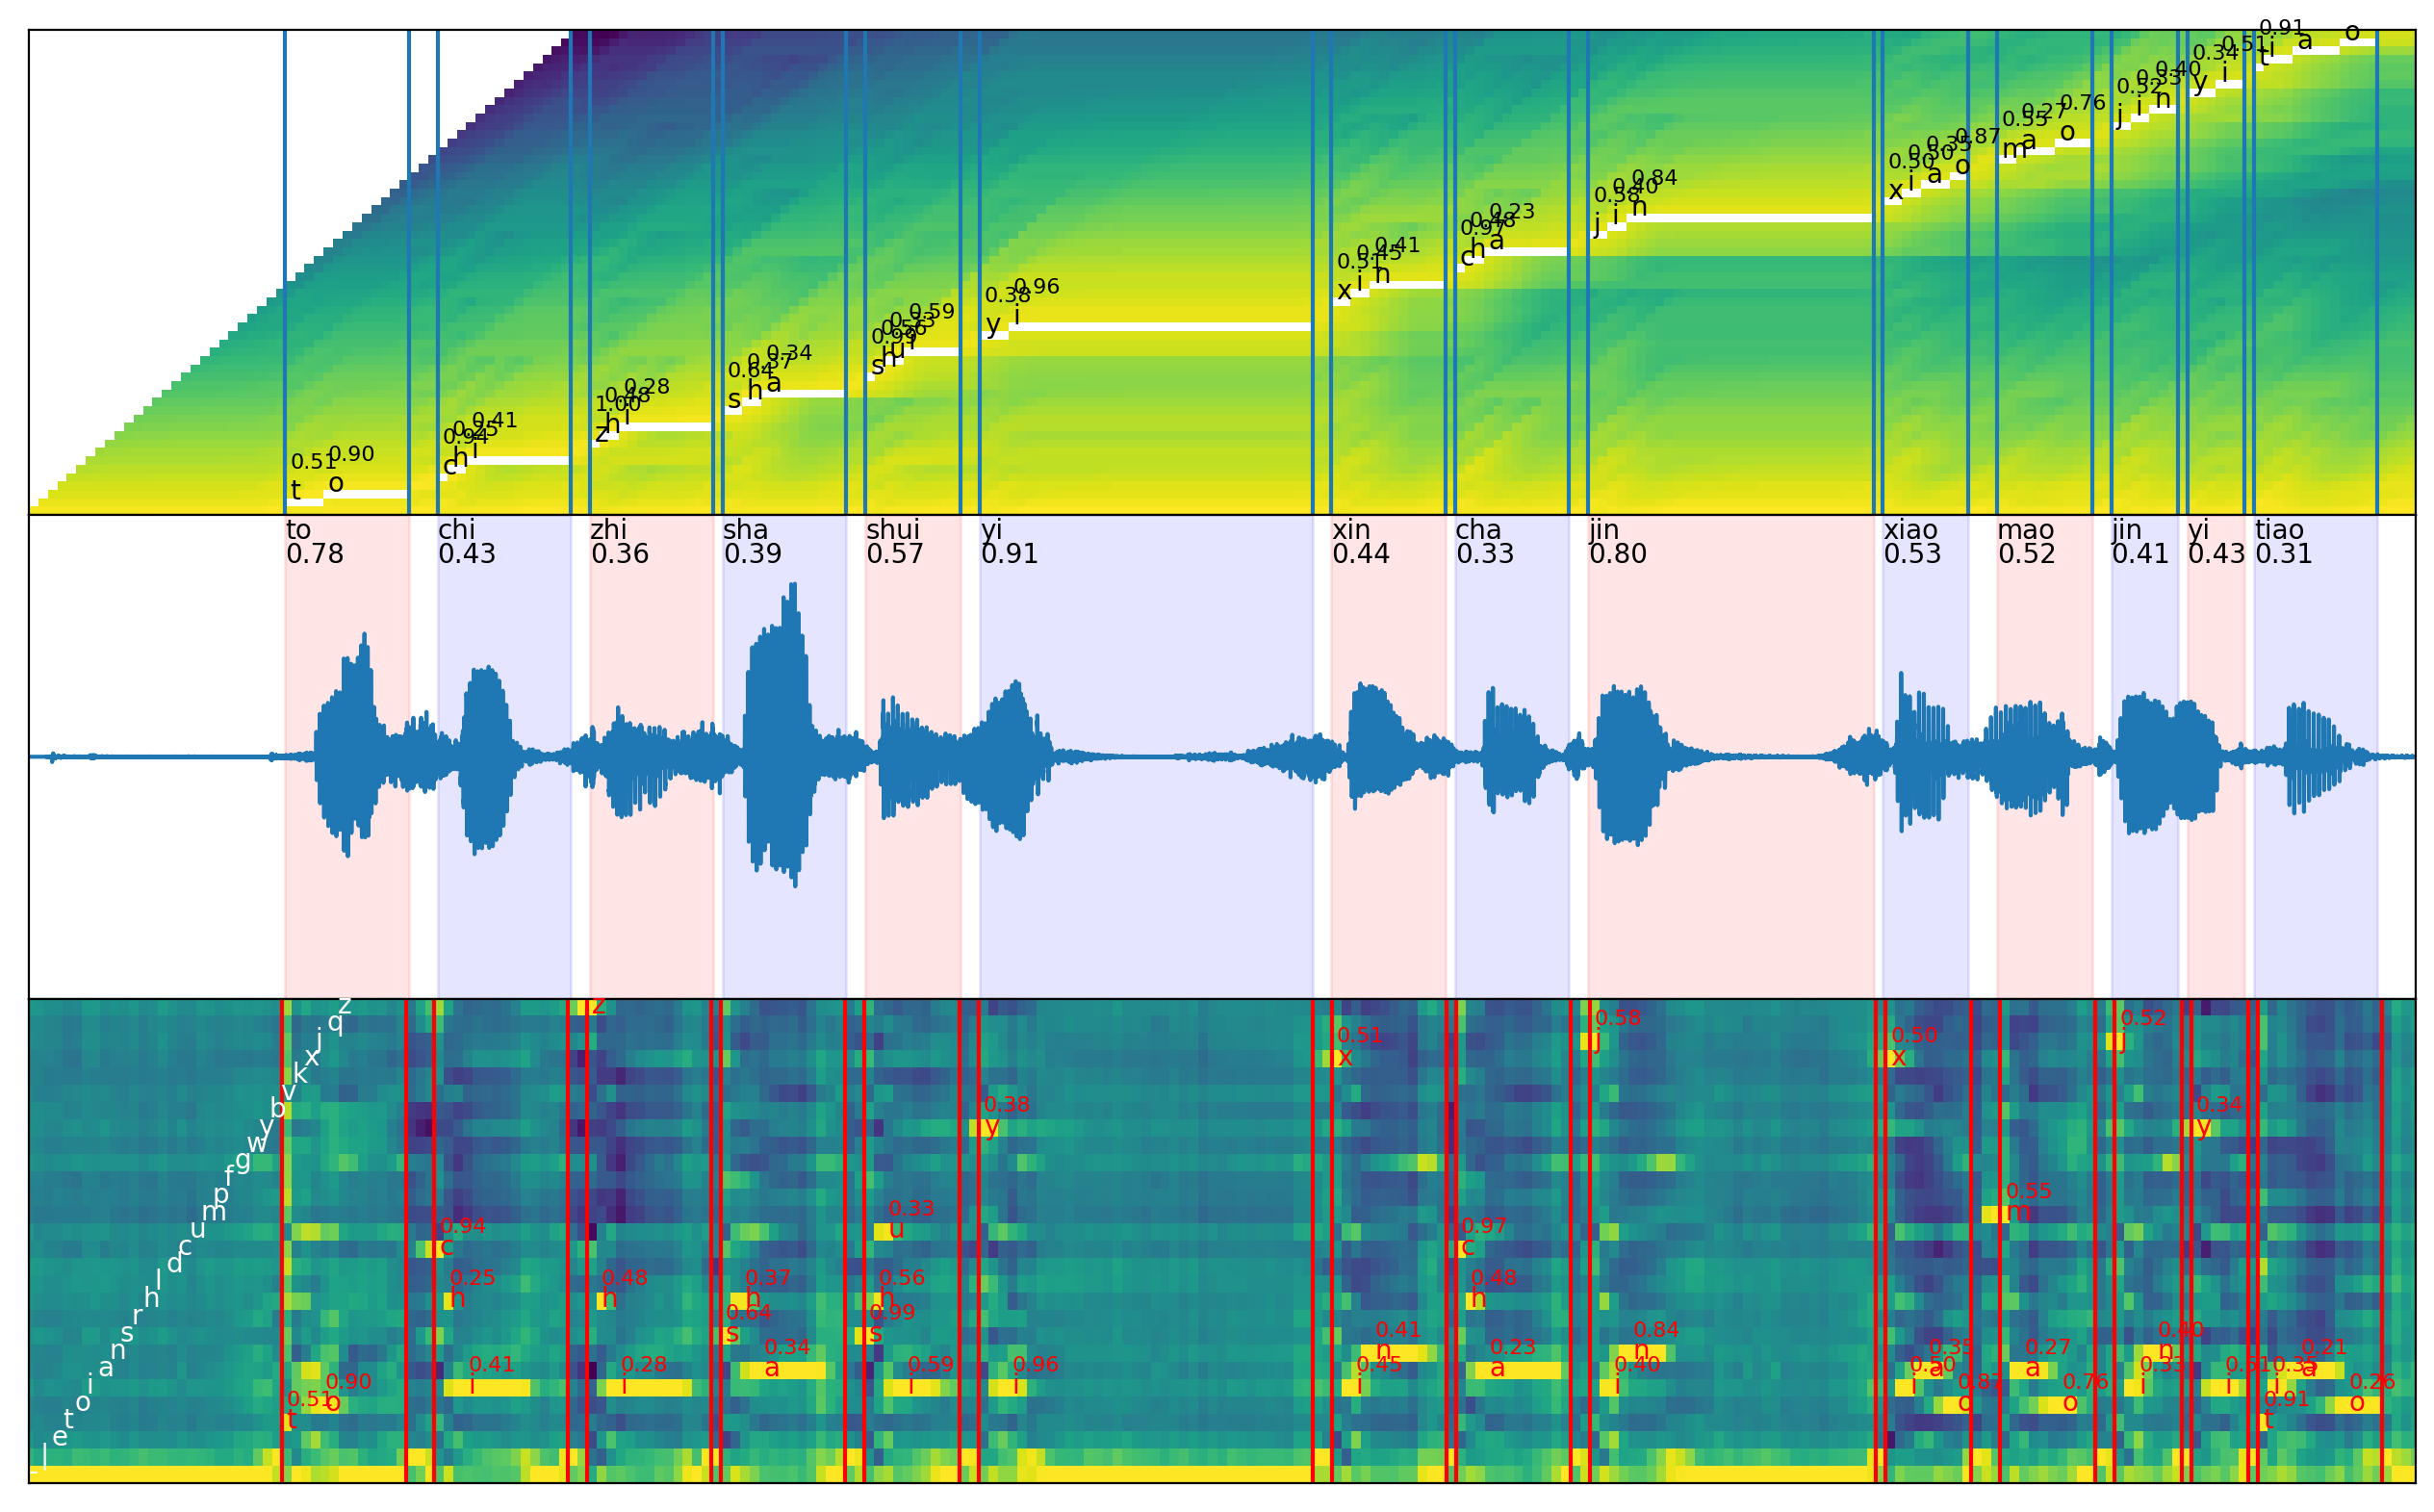

In [572]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(16, 10))
    # prediction path
    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower", interpolation='none', aspect='auto')
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)


    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform / (max(-min(waveform), max(waveform))*1.4))
    color = 'red'
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color=color)
        color = 'red' if color == 'blue' else 'blue'
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))
        ax2.annotate(f"{word.label}", (x0, 0.9))

    ax2.set_yticks([])
    ax2.set_xticks([])
    ax2.set_ylim(-1, 1)
    ax2.set_xlim(0, waveform.size(-1))
    # prediction position
    ax3.imshow(emission.T, origin="lower", interpolation='none', aspect='auto')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_xlim(0, len(emission)-1)
    for word in word_segments:
        ax3.axvline(word.start - 0.5, color = 'red')
        ax3.axvline(word.end - 0.5, color = 'red')
    for i, seg in enumerate(segments):
        if seg.label != "|":
            id = loaderGenerator.label2id(type_code, seg.label)[0]
            ax3.annotate(seg.label, (seg.start, id -0.3), color='red')
            ax3.annotate(f"{seg.score:.2f}", (seg.start, id + 1), fontsize=8, color='red')
    for i, label in enumerate(labels):
        ax3.annotate(label, (i*1.2, i - 0.3), color='white')
    plt.subplots_adjust(wspace =0, hspace =0)
    plt.show()

plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)

In [573]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * (word.start))
    x1 = int(ratio * (word.end) - 1)
    filename = f"_assets/{i}_{word.label}.wav"
    torchaudio.save(filename, waveform[:, x0:x1], builder.sample_rate)
    print(f"{word.label} ({word.score:.2f}): {x0 / builder.sample_rate:.3f} - {x1 / builder.sample_rate:.3f} sec")
    return Audio(filename)

In [574]:
# Generate the audio for each segment
print(transcript)
i = 0

['|', 't', 'o', '|', 'c', 'h', 'i', '|', 'z', 'h', 'i', '|', 's', 'h', 'a', '|', 's', 'h', 'u', 'i', '|', 'y', 'i', '|', '|', 'x', 'i', 'n', '|', 'c', 'h', 'a', '|', 'j', 'i', 'n', '|', 'x', 'i', 'a', 'o', '|', 'm', 'a', 'o', '|', 'j', 'i', 'n', '|', 'y', 'i', '|', 't', 'i', 'a', 'o', '|']


In [575]:
sample['text']

'陶瓷紫砂随意 新茶巾 小毛巾 一条'

In [550]:
display_segment(i)
i+=1

jian (0.58): 1.325 - 1.505 sec
please check ./audio-temp.wav for audio
